In [19]:
### Comparaison 2SLS vs Weighting to estimate group LATE
### Jeremy L'Hour
### 15/10/2019


### FUNCTIONS AND PACKAGES
#install.packages("AER")
#install.packages("gridExtra")
library("AER")
library("ggplot2")
library("gridExtra")

dgp <- function(n,tau.h=1,tau.l=-1){
	md_x = 0.25 + .4*as.numeric(runif(n) < .5)
	Z = as.numeric(runif(n) < md_x)
	eta = rnorm(n,sd=.7)
	D = .2 + .5*Z + eta
    # Define groups
    gamma = rexp(n)
    high.effect     = quantile(gamma, .8)
    low.effect      = quantile(gamma, .2)
    high            = as.numeric(gamma>high.effect)
    low             = as.numeric(gamma<low.effect)
	Y = .6 + tau.l*low*D + tau.h*high*D + .5*(tau.l+tau.h)*(1-low-high)*D + (eta + rnorm(n))
	return(data.frame(Y=Y,
					  D=D,
					  Z=Z,
					  gamma=gamma,
					  md_x=md_x))
}

In [20]:
### SIMULATIONS
R = 10000
tau0.l = -.3
tau0.h = .5
thres = .2
r = matrix(nrow=R, ncol=4)

set.seed(69742)
t_start = Sys.time()
for(i in 1:R){
	data <- dgp(n=500,tau.h=tau0.h,tau.l=tau0.l)

	high.effect     = quantile(data$gamma, 1-thres)
    low.effect      = quantile(data$gamma, thres)
    data[,"h"]      = as.numeric(data$gamma>high.effect)
    data[,"l"]      = as.numeric(data$gamma<low.effect)

	data[,"Dh"]     = data[,"D"]*data$h
  	data[,"Dl"]     = data[,"D"]*data$l
  	data[,"Dn"]     = data[,"D"]*(1-data$h-data$h)
  	data[,"Zhd"]    = (data[,"Z"]-data[,"md_x"])*data$h
  	data[,"Zld"]    = (data[,"Z"]-data[,"md_x"])*data$l
  	data[,"Znd"]    = (data[,"Z"]-data[,"md_x"])*(1-data$h-data$h)
  	data[,"Zh"]     = data[,"Z"]*data$h
  	data[,"Zl"]     = data[,"Z"]*data$l
  	data[,"Zn"]     = data[,"Z"]*(1-data$h-data$h)
    
    data[,"w"]      = 1/(data[,"md_x"]*(1-data[,"md_x"]))

	### A. Weighting
	reg.w <- ivreg(Y ~ Dh + Dl + Dn - 1 | Zhd + Zld + Znd - 1, data=data,weight=data[,"w"])

	### B. 2SLS
	reg.2sls <- ivreg(Y ~ Dh + Dl + Dn | Zh + Zl + Zn, data=data)

	### C. Computing

	### D. Saving results
	r[i,] <- c(coef(reg.w)["Dh"]-tau0.h,coef(reg.w)["Dl"]-tau0.l,
               coef(reg.2sls)["Dh"]-tau0.h,coef(reg.2sls)["Dl"]-tau0.l)
}
print(Sys.time()-t_start)

Time difference of 1.423451 mins


In [21]:
### DISPLAY
### COMPUTE BIAS AND RMSE
StatDisplay = data.frame()
StatDisplay[1:4,"bias"] =  abs(apply(r,2,mean))
StatDisplay[1:4,"MSE"] = apply(r^2,2,mean)
row.names(StatDisplay) = c("weighting.high","weighting.low","2SLS.high","2SLS.low")
print(StatDisplay)

                     bias         MSE
weighting.high 0.20213764  25.7585539
weighting.low  0.55445821 939.7027184
2SLS.high      0.03536803   0.2604958
2SLS.low       0.11692097   0.1138404


Warning message:
“Removed 193 rows containing non-finite values (stat_bin).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 201 rows containing non-finite values (stat_bin).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”Warning message:
“Removed 2 rows containing missing values (geom_bar).”

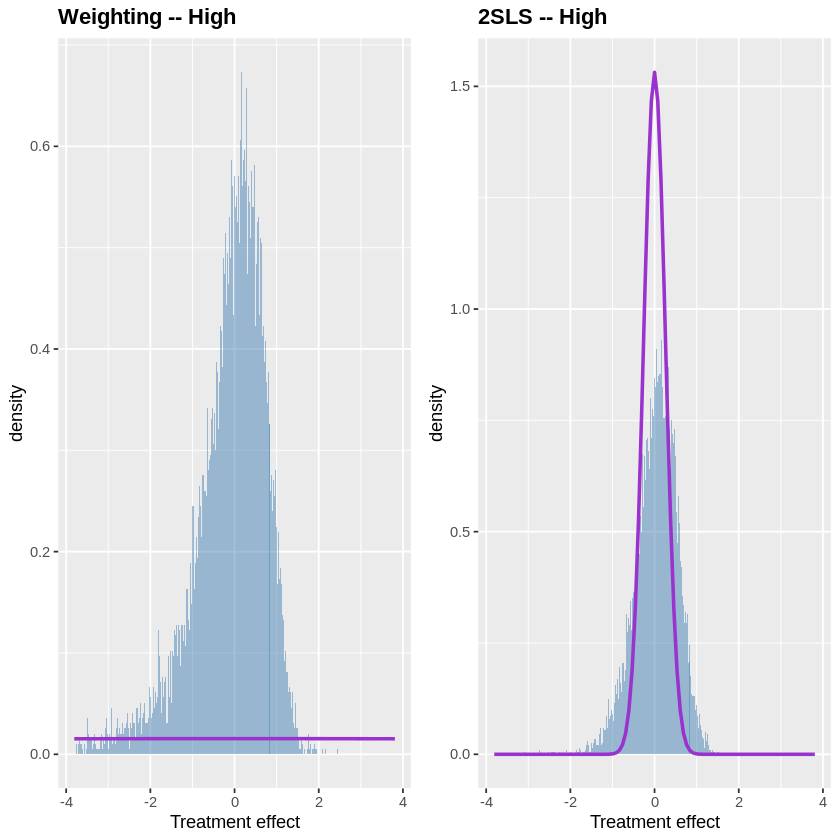

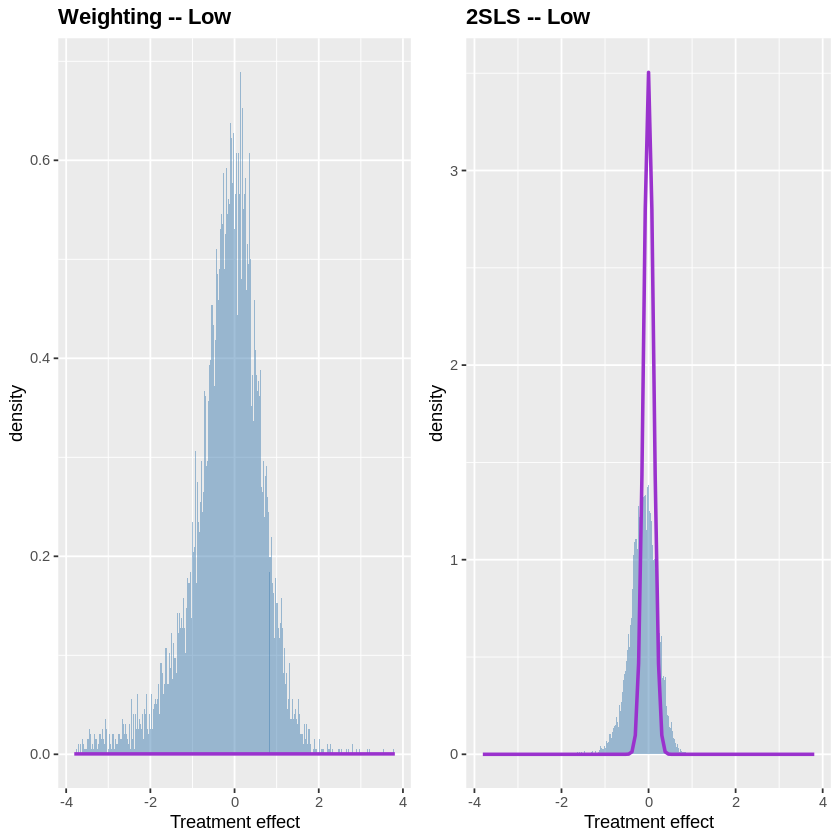

In [22]:
### DRAW CHARTS
id = c(mapply(function(x) rep(x,R),1:4))
val = c(r)
data_res = data.frame(val = val, model = id)

M = max(abs(quantile(r,.01,na.rm=T)),abs(quantile(r,.99,na.rm=T)))
lb = -1.1*M; ub = 1.1*M

get.plot <- function(data,modelS,title="A Title",s){
  plot_res <- ggplot(subset(data, (model==modelS)), aes(x=val)) + 
    geom_histogram(binwidth = .02, alpha=.5, position='identity',fill="steelblue", aes(y = ..density..)) +
    scale_x_continuous(limits=c(lb,ub), name="Treatment effect") +
    ggtitle(title) + 
    stat_function(fun = dnorm, args=list(mean=0, sd=s), colour="darkorchid3", size=1) +
    theme(plot.title = element_text(lineheight=.8, face="bold"),legend.position="none")
  return(plot_res)
} # plot func

grid.arrange(get.plot(data_res,1,"Weighting -- High",StatDisplay[1,"MSE"]), get.plot(data_res,3,"2SLS -- High", StatDisplay[3,"MSE"]),ncol=2)
              
grid.arrange(get.plot(data_res,2,"Weighting -- Low", StatDisplay[2,"MSE"]), get.plot(data_res,4,"2SLS -- Low", StatDisplay[4,"MSE"]),ncol=2)

